In [28]:
import numpy as np
import xarray as xr
import os
import pandas as pd
import glob

In [29]:
import sys ; sys.path.append("../..")
from ppe_tools import *

In [30]:
csv='lhc_220926.csv'

In [4]:
#data_url = '"https://docs.google.com/spreadsheets/d/e/2PACX-1vQLjMUT7sgunI4XkbGWq_RrjrLhR8-N0RiojM7h3lbSsN5-jgKIFyiJtPJeQkTEf2TL4ouLu_dqmEkg/pub?gid=737792973&single=true&output=csv"'
#cmd = 'curl -L '+data_url+' > '+csv # need to add -L option to force redirects
#os.system(cmd)

In [61]:
df = pd.read_csv(csv)
params=df['param'].values
params

array(['FUN_fracfixers', 'KCN', 'a_fix', 'crit_dayl', 'd_max', 'fff',
       'froot_leaf', 'fstor2tran', 'grperc', 'jmaxb0', 'jmaxb1', 'kcha',
       'kmax', 'krmax', 'leaf_long', 'leafcn', 'lmr_intercept_atkin',
       'lmrha', 'lmrhd', 'medlynintercept', 'medlynslope', 'nstem',
       'psi50', 'q10_mr', 'slatop', 'soilpsi_off', 'stem_leaf',
       'sucsat_sf', 'theta_cj', 'tpu25ratio', 'tpuse_sf', 'wc2wjb0'],
      dtype=object)

In [6]:
kcns=['kc_nonmyc',
        'kn_nonmyc',
        'akc_active',
        'akn_active',
        'ekc_active',
        'ekn_active']
kcns

['kc_nonmyc',
 'kn_nonmyc',
 'akc_active',
 'akn_active',
 'ekc_active',
 'ekn_active']

In [18]:
lhcs = {}
for p in params:
    ix       = df['param']==p
    minval   = df['min'][ix].values[0]
    maxval   = df['max'][ix].values[0]
    pftmin   = df['pft_mins'][ix].values[0]
    pftmax   = df['pft_maxs'][ix].values[0]
    thisloc  = df['loc'][ix].values[0]
    if p=='KCN':
        flag='KCN'
    else:
        flag=''
    
    needs_pft = (minval=='pft')
    if needs_pft:
        thismin = np.fromstring(pftmin, dtype='float', sep=',')
    elif 'percent' in minval:
        thismin = minval
    else:
        thismin = np.array(float(minval))

    needs_pft = (maxval=='pft')
    if needs_pft:
        thismax = np.fromstring(pftmax, dtype='float', sep=',')
    elif 'percent' in maxval:
        thismax = maxval
    else:
        thismax = np.array(float(maxval))

    if p!='KCN':
        lhcs[p]={'min':thismin,'max':thismax,'loc':thisloc,'flagged':[]}
    else:
        flagged={}
        for kcn in kcns:
            flagged[kcn]={'min':thismin,'max':thismax,'loc':thisloc}
        lhcs[p]={'min':[],'max':[],'loc':thisloc,'flagged':flagged}

### start editing from here onward

In [43]:
def get_p(p,i):
    #replace np.random.rand() with some function that returns the correct param weighting 
    return np.random.rand()

In [44]:
# specify where your samples exist
# make sure that they are in the same order as the params in lhcs above
exp1=[[get_p(p,i) for p in lhcs] for i in range(48)]

In [45]:
#should have 48 members
len(exp1)

48

In [46]:
#should have 32 param weightings per member
len(exp1[0])

32

In [9]:
#instantiate the Ensemble object
basefile = '/glade/scratch/djk2120/PPEn11/paramfiles/OAAT0000.nc'  #replace with /glade/campaign/asp/...
pdir = '/glade/scratch/djk2120/PPEn11/paramfiles/'
ndir = '/glade/scratch/djk2120/PPEn11/namelist_mods/'
x    = Ensemble(basefile,pdir,ndir)

#add the new LHCs
prefix = 'LHC'   #make your own prefix
nextnum=1
n_samples=500  #fix this
x.add_lhcs(lhcs,prefix,nextnum,n_samples,lhc=exp1)

In [10]:
x.write(lhcfile='/glade/scratch/djk2120/PPEn11/lhc220926.txt')  #change to a file for your experiment

### do the paramfiles match the csv?

In [60]:
key='/glade/campaign/asp/djk2120/PPEn11/csvs/lhc220926.txt'
df2=pd.read_csv(key)
vmin=float(df['min'][df['param']==v].values)
vmax=float(df['max'][df['param']==v].values)

In [94]:
files=sorted(glob.glob('/glade/campaign/asp/djk2120/PPEn11/paramfiles/LHC*'))
v='FUN_fracfixers'
def preprocess(ds):
    return ds[v]
da=xr.open_mfdataset(files[1:],combine='nested',concat_dim='ens',preprocess=preprocess,decode_times=False)



In [95]:
fromthecsv=[vmin+wt*(vmax-vmin) for wt in df2[v]]

In [99]:
import matplotlib.pyplot as plt

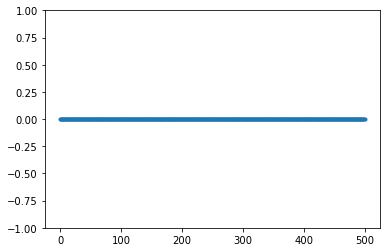

In [101]:
plt.plot(np.array(fromthecsv)-da.isel(pft=1).values,'.')
plt.ylim([vmin-vmax,vmax-vmin]);

### inspecting lhc

In [20]:
from skopt.space import Space
from skopt.sampler import Lhs

In [21]:
n_samples=500
space = Space([(0.,1.) for p in params])
lhs = Lhs(lhs_type="classic", criterion=None)
lhc = lhs.generate(space.dimensions, n_samples)